In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
registration_df = pd.read_csv("data/registration_data_training.csv")
columns_to_drop = ['registration_platform_specific', 'registration_country', 'registration_store', 'registration_channel_detailed', 'registration_device_type', 'registration_device_manufacturer', 'avg_age_top_11_players',
                  'registration_season_day', 'tokens_bought', 'avg_stars_top_11_players', 'number_of_devices_used', 'transaction_count_iap', 'tokens_bought', 'morale_spent', 'total_match_won_count', 'tokens_spent', 'rests_stash']


#columns_to_drop = ['registration_platform_specific', 'registration_country', 'registration_store', 'registration_channel_detailed', 'registration_device_type', 'registration_device_manufacturer']

registration_df = registration_df.drop(columns=columns_to_drop)

In [3]:
def encode_columns(df):
    for col in df.columns:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(int)
    
    df['registration_date'] = pd.to_datetime(df['registration_date'], dayfirst=False)

    return df

def create_last_registration_columns(df):
    df = df.sort_values(by=['user_id', 'registration_date'])

    # Kreiramo novu kolonu sa pomerenim datumima registracije (shift) za svakog korisnika
    df['last_registration_date'] = df.groupby('user_id')['registration_date'].shift(1)

    # Izračunavamo razliku u danima između 'registration_date' i 'last_registration_date'
    df['days_passed_last_registration'] = (df['registration_date'] - df['last_registration_date']).dt.days

    # Zamenjujemo NaN vrednosti sa 0 za prvi red svakog korisnika gde nema prethodnog datuma
    df['days_passed_last_registration'] = df['days_passed_last_registration'].fillna(0).astype(int)

    # Kreiramo novu kolonu sa poslednjim danima aktivnog života za svakog korisnika
    df['last_days_active_lifetime'] = df.groupby('user_id')['days_active_lifetime'].shift(1)

    # Zamenjujemo NaN vrednosti sa 0 za prvi red svakog korisnika gde nema prethodnog dana aktivnog života
    df['last_days_active_lifetime'] = df['last_days_active_lifetime'].fillna(0).astype(int)

    return df


lives_df = pd.read_csv("data/previous_lives_training_data.csv")
columns_to_drop  = ['registration_channel_detailed', 'registration_country', 'registration_store', 'registration_platform_specific']
lives_df = lives_df.drop(columns=columns_to_drop)


lives_df = encode_columns(lives_df)
lives_df = create_last_registration_columns(lives_df)
lives_df['num_previous_lives'] = lives_df.groupby('user_id').cumcount() + 1

In [4]:
# Uzimanje poslednjeg reda za svakog korisnika u lives_df
latest_lives = lives_df.sort_values(by=['user_id', 'registration_date']).groupby('user_id').last()

# Biramo samo relevantne kolone iz lives_df
latest_lives = latest_lives[['is_rewarded_video_watcher_lifetime', 'is_payer_lifetime', 'days_active_lifetime', 'num_previous_lives', 'registration_date']]

# Merge sa registration_df na osnovu user_id
expanded_registration_df = registration_df.merge(latest_lives, on='user_id', how='left')


# Pretpostavljamo da je registration_time_utc u formatu datuma/vremena
expanded_registration_df['registration_time_utc'] = pd.to_datetime(expanded_registration_df['registration_time_utc'])

# Konverzija registration_date u datetime (ako već nije)
expanded_registration_df['registration_date'] = pd.to_datetime(expanded_registration_df['registration_date'])

# Dodajemo novu kolonu days_passed_since_last_registration
expanded_registration_df['days_passed_since_last_registration'] = (
    expanded_registration_df['registration_time_utc'] - expanded_registration_df['registration_date']
).dt.days



In [5]:
expanded_registration_df.columns

Index(['user_id', 'registration_time_utc', 'session_count', 'playtime',
       'total_match_played_count', 'total_match_watched_count',
       'transaction_count_rewarded_video', 'tokens_stash', 'rests_spent',
       'treatments_spent', 'money_stash', 'avg_stars_top_3_players',
       'training_count', 'days_active_first_28_days_after_registration',
       'is_rewarded_video_watcher_lifetime', 'is_payer_lifetime',
       'days_active_lifetime', 'num_previous_lives', 'registration_date',
       'days_passed_since_last_registration'],
      dtype='object')

In [6]:
columns_to_drop = ['user_id', 'registration_time_utc', 'registration_date']
expanded_registration_df = expanded_registration_df.drop(columns=columns_to_drop)

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Pretpostavljamo da je expanded_registration_df već pripremljen i da sadrži ciljnu promenljivu
# Ciljna promenljiva
target = 'days_active_first_28_days_after_registration'

# Podela na ulazne i ciljnu promenljivu
X = expanded_registration_df.drop(columns=[target])  # Svi atributi osim ciljne promenljive
y = expanded_registration_df[target]

# Podela na trening i validacioni skup (80:20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Kreiranje XGBoost modela
xgb_model = XGBRegressor(
    tree_method="hist",
    max_depth = 3,
    min_child_weight = 5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma = 0,
    eval_metric=mean_absolute_error,
)

# Treniranje modela
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
)

# Predikcija na validacionom skupu
y_pred = xgb_model.predict(X_val)

y_pred = np.clip(y_pred, 0, 28)

# Evaluacija - MAE
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error (MAE) on validation set: {mae:.2f}")


[0]	validation_0-rmse:8.92384	validation_0-mean_absolute_error:7.42330
[1]	validation_0-rmse:8.53199	validation_0-mean_absolute_error:6.99894
[2]	validation_0-rmse:8.30781	validation_0-mean_absolute_error:6.70944
[3]	validation_0-rmse:8.20326	validation_0-mean_absolute_error:6.53366
[4]	validation_0-rmse:8.11270	validation_0-mean_absolute_error:6.38683
[5]	validation_0-rmse:8.06267	validation_0-mean_absolute_error:6.28015
[6]	validation_0-rmse:8.02599	validation_0-mean_absolute_error:6.20248
[7]	validation_0-rmse:8.00051	validation_0-mean_absolute_error:6.14837
[8]	validation_0-rmse:7.98405	validation_0-mean_absolute_error:6.10260
[9]	validation_0-rmse:7.97120	validation_0-mean_absolute_error:6.07081
[10]	validation_0-rmse:7.96391	validation_0-mean_absolute_error:6.03824
[11]	validation_0-rmse:7.96327	validation_0-mean_absolute_error:6.01999
[12]	validation_0-rmse:7.96064	validation_0-mean_absolute_error:6.00219
[13]	validation_0-rmse:7.95544	validation_0-mean_absolute_error:5.98900
[1

In [ ]:
# Funkcija za mapiranje vrednosti na kvartile
def map_to_quartile(value):
    if 0 <= value <= 14:
        return 1
    else:
        return 2

# Mapiranje stvarnih i prediktovanih vrednosti na kvartile
y_val_quartiles = y_val.apply(map_to_quartile)
y_pred_quartiles = pd.Series(y_pred, index=y_val.index).apply(map_to_quartile)  # Usaglašavanje indeksa

# Izračunavanje tačnosti po kvartilima
quartile_accuracies = {}
quartile_counts = {}
for quartile in range(1, 3):
    # Filtriranje vrednosti za trenutni kvartil
    mask = y_val_quartiles == quartile
    correct_predictions = (y_val_quartiles[mask] == y_pred_quartiles[mask]).sum()
    total_predictions = mask.sum()
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    quartile_accuracies[quartile] = accuracy
    quartile_counts[quartile] = total_predictions

# Prikaz tačnosti i broja uzoraka po kvartilima
for quartile, accuracy in quartile_accuracies.items():
    count = quartile_counts[quartile]
    print(f"Quartile {quartile}: Accuracy = {accuracy:.2%}, Total Samples = {count}")


Quartile 1: Accuracy = 91.16%, Total Samples = 7679
Quartile 2: Accuracy = 39.60%, Total Samples = 2321


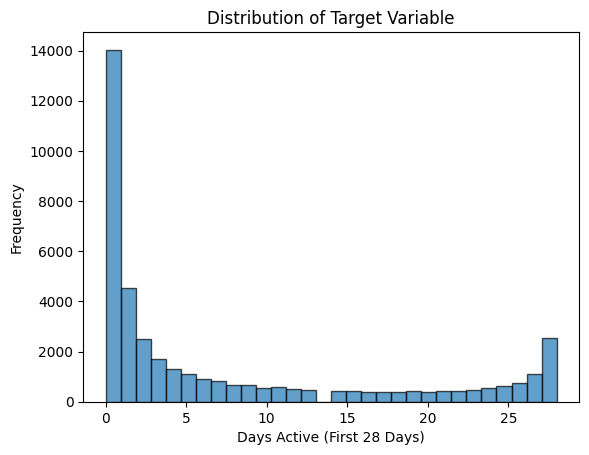

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y_train, bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Target Variable")
plt.xlabel("Days Active (First 28 Days)")
plt.ylabel("Frequency")
plt.show()


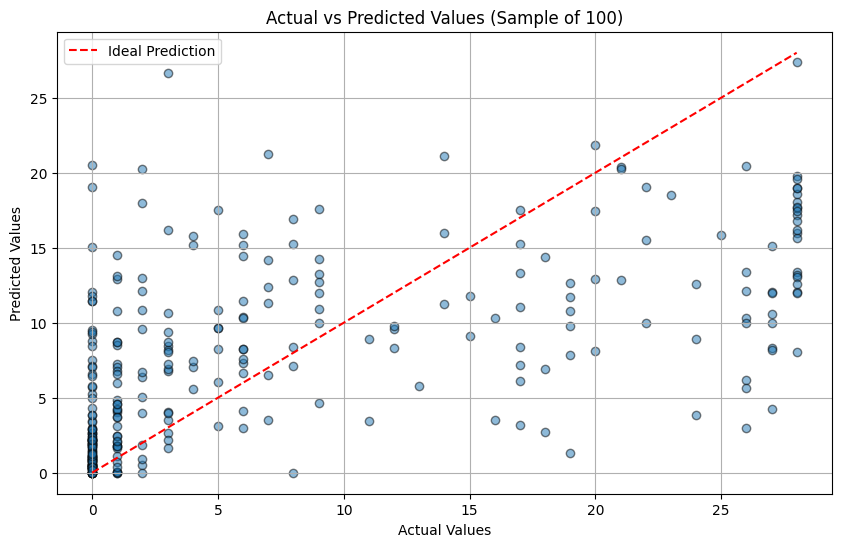

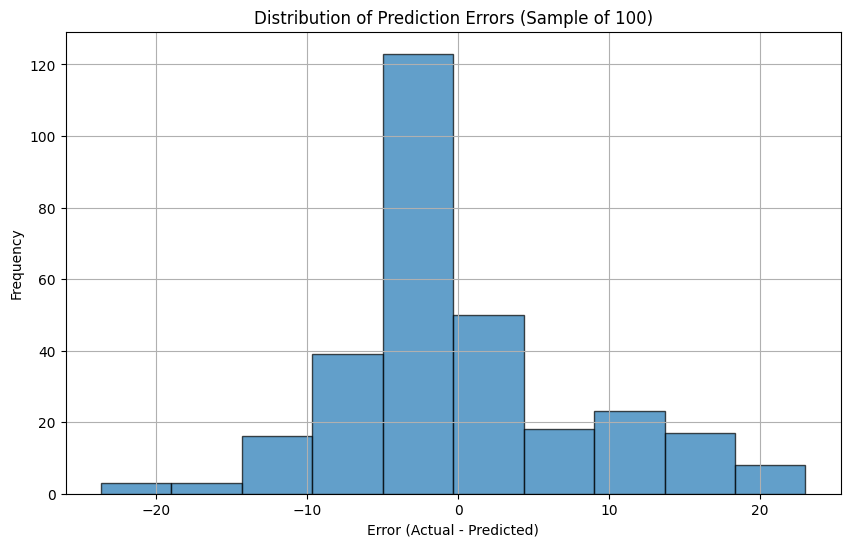

In [ ]:
import matplotlib.pyplot as plt

# Odabir uzorka od 100 primera za pregledniji prikaz
sample_indices = np.random.choice(y_val.index, size=300, replace=False)
y_val_sample = y_val.loc[sample_indices]
y_pred_sample = pd.Series(y_pred, index=y_val.index).loc[sample_indices]

# Scatter plot: Stvarne vrednosti vs Prediktovane vrednosti
plt.figure(figsize=(10, 6))
plt.scatter(y_val_sample, y_pred_sample, alpha=0.5, edgecolor='k')
plt.plot([0, 28], [0, 28], color='red', linestyle='--', label="Ideal Prediction")
plt.title("Actual vs Predicted Values (Sample of 100)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.legend()
plt.show()

# Histogram grešaka za uzorak od 100 primera
errors_sample = y_val_sample - y_pred_sample
plt.figure(figsize=(10, 6))
plt.hist(errors_sample, bins=10, edgecolor='k', alpha=0.7)
plt.title("Distribution of Prediction Errors (Sample of 100)")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


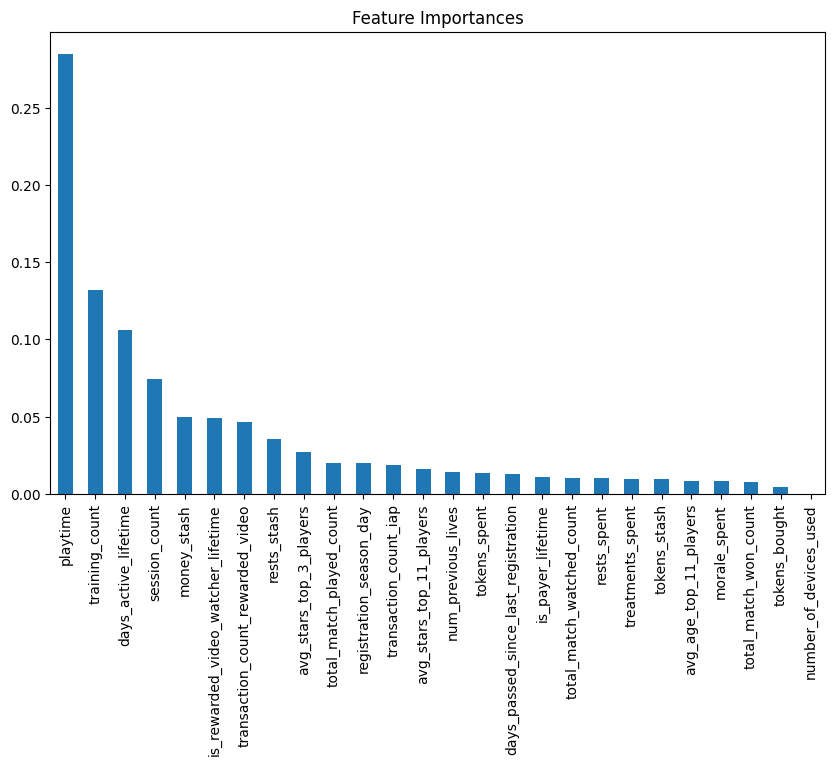

In [ ]:
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title("Feature Importances")
plt.show()


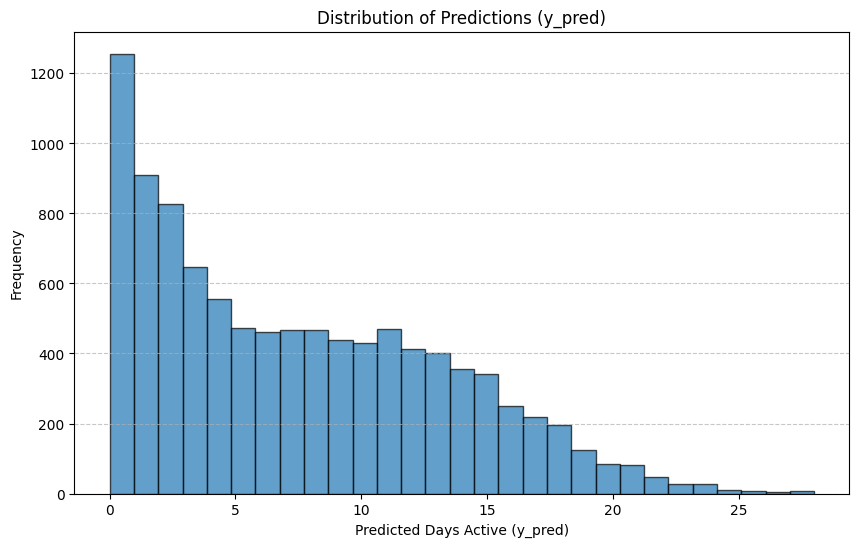

In [ ]:
import matplotlib.pyplot as plt

# Kreiranje histograma sa 29 binova
plt.figure(figsize=(10, 6))
plt.hist(y_pred, bins=29, edgecolor='black', alpha=0.7)
plt.title('Distribution of Predictions (y_pred)')
plt.xlabel('Predicted Days Active (y_pred)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
